# Concept to predict (generate) p margin upon burnup core configuration

In [10]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..'))) # imports top level

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import display
import scipy

In [11]:

df = pd.read_excel("input.xlsx", sheet_name="no_burnup")

In [12]:
df.columns

Index(['Name', '7-6_s', '7-5_s', '7-4_s', '7-3_s', '6-6_s', '6-5_s', '6-4_s',
       '6-3_s', '5-6_s', '5-3_s', '4-6_s', '4-3_s', '3-6_s', '3-5_s', '3-4_s',
       '3-3_s', '2-6_s', '2-5_s', '2-4_s', '2-3_s', '7-6_b', '7-5_b', '7-4_b',
       '7-3_b', '6-6_b', '6-5_b', '6-4_b', '6-3_b', '5-6_b', '5-3_b', '4-6_b',
       '4-3_b', '3-6_b', '3-5_b', '3-4_b', '3-3_b', '2-6_b', '2-5_b', '2-4_b',
       '2-3_b', '7-6_t', '7-5_t', '7-4_t', '7-3_t', '6-6_t', '6-5_t', '6-4_t',
       '6-3_t', '5-6_t', '5-3_t', '4-6_t', '4-3_t', '3-6_t', '3-5_t', '3-4_t',
       '3-3_t', '2-6_t', '2-5_t', '2-4_t', '2-3_t', 'p_mar'],
      dtype='object')

In [13]:
d = display.Display(df=df)
d.quick_processing()

The columns with prefix  are not in DataFrame
The columns with prefix None are not in DataFrame


In [14]:
df = d.df

# Predicting p margin

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Normalizer, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, Exponentiation, PairwiseKernel, Matern,
    
)

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [68]:
df_p = df.loc[
    :, 
    [
        "p_mar",
        *d.CORE_PARTS["left"]["ALL_CELLS"],
        *d.CORE_PARTS["burnup"]["ALL_CELLS"],
        "average_l",
        "average_b",
    ]
]

In [69]:
df_p

,p_mar,7-6_l,7-5_l,7-4_l,7-3_l,6-6_l,6-5_l,6-4_l,6-3_l,5-6_l,...,3-6_b,3-5_b,3-4_b,3-3_b,2-6_b,2-5_b,2-4_b,2-3_b,average_l,average_b
0,6.698140,244.74,212.04,234.36,192.33,167.9835,201.9300,226.2570,130.1150,166.2875,...,85.2770,38.7430,96.6190,81.2490,111.33,154.17,100.95,111.12,188.644250,95.605750
1,3.613529,97.44,164.85,172.68,242.31,113.3140,200.2340,136.8990,148.6650,180.3325,...,128.1010,148.1615,26.1820,112.6250,87.90,87.84,128.28,109.26,171.748750,112.501250
2,5.010686,243.96,212.94,189.51,152.94,180.3060,165.0950,96.8840,197.6635,143.7095,...,50.8005,57.9820,121.1315,112.9165,106.32,84.96,94.23,158.70,183.272375,100.977625
3,5.671946,166.80,189.00,228.36,170.85,210.5955,180.7830,180.0410,215.0740,232.0075,...,80.4540,96.5660,37.5505,98.7125,139.44,174.42,68.28,100.89,183.948900,100.301100
4,7.741418,170.85,213.99,236.49,182.94,140.0790,208.5550,144.6370,150.9175,186.8780,...,103.4825,93.9955,157.8340,30.7665,73.14,59.58,134.70,78.51,194.832400,89.417600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,8.025679,148.65,187.71,156.66,251.19,187.8585,164.9625,190.5880,172.6740,264.1785,...,132.1290,59.0420,96.1420,85.9660,64.65,41.52,164.10,77.22,196.597625,87.652375
543,7.449398,164.07,143.31,149.31,256.74,139.2310,248.2785,203.0695,178.5305,156.4030,...,9.5135,127.6505,46.5605,144.3190,69.36,101.58,81.57,94.89,193.393450,90.856550
544,6.174647,245.13,211.89,151.86,218.97,184.3075,224.9055,201.1085,141.0595,159.1855,...,49.3430,40.8895,128.5515,91.7960,84.42,119.58,107.85,155.43,187.261325,96.988675
545,7.445115,112.02,226.68,212.97,196.95,199.8630,237.5460,216.5845,158.1520,186.2155,...,27.5865,90.0205,97.2285,74.8890,93.54,109.29,132.87,122.22,192.246825,92.003175


In [70]:
y_p = df.loc[:, "p_mar"]
X_raw_p = df_p.drop("p_mar", axis=1)

In [71]:
ct_p = ColumnTransformer(
    [
        ("", StandardScaler(), X_raw_p.columns)
    ]
).set_output(transform="pandas")

In [72]:
X_p = ct_p.fit_transform(X_raw_p)

In [73]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

In [74]:
rfr = RandomForestRegressor()
ada = AdaBoostRegressor()

kernel2 = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + 5.0 * RBF(length_scale=1, length_scale_bounds=(1e-5, 1e5)) + WhiteKernel(noise_level=.1, noise_level_bounds=(1e-5, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel2)

In [75]:
rfr.fit(X_train_p, y_train_p)
ada.fit(X_train_p, y_train_p)
gpr.fit(X_train_p, y_train_p)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + 2.24**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1))

In [76]:
y_rfr_p = rfr.predict(X_test_p)
y_ada_p = ada.predict(X_test_p)
y_gpr_p = gpr.predict(X_test_p)

In [77]:
rfr.score(X_test_p, y_test_p), ada.score(X_test_p, y_test_p), gpr.score(X_test_p, y_test_p)

(0.954709703041723, 0.9440808666127724, 0.9973140391840827)

In [78]:
mean_absolute_error(
    y_rfr_p, 
    y_test_p
), mean_absolute_error(
        y_ada_p, 
        y_test_p
)

(0.2426304508166034, 0.2764365478717205)

In [79]:
mean_absolute_error(
    y_gpr_p, 
    y_test_p
), mean_absolute_error(
        y_gpr_p, 
        y_test_p
)

(0.060386703128306324, 0.060386703128306324)

In [80]:
( (y_gpr_p - y_test_p)**2 / ( len(y_test_p) - 2 ) ).sum()*1.96

0.011789490048383212

<Axes: xlabel='p_mar', ylabel='p_mar'>

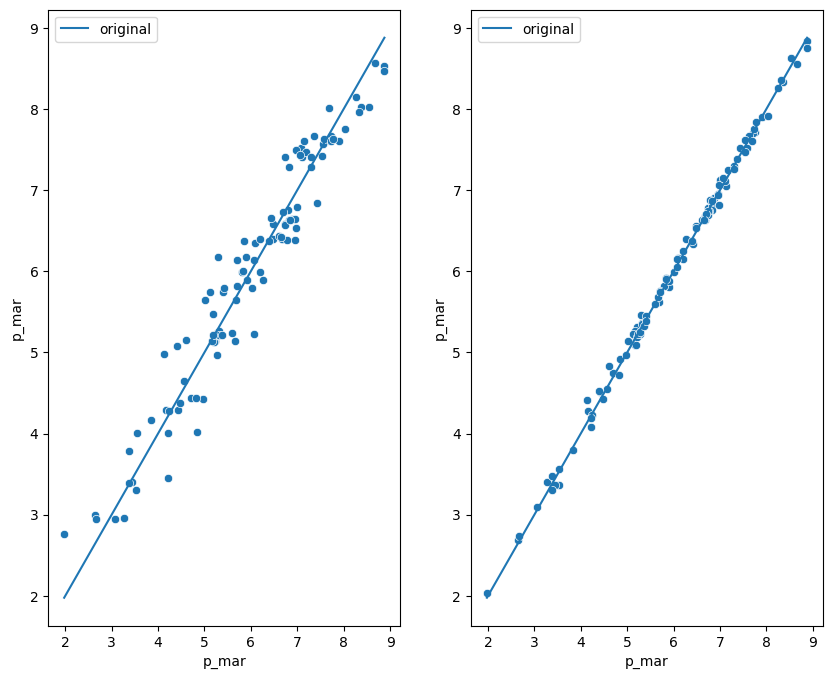

In [81]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
sns.scatterplot(x=y_test_p, y=y_ada_p, ax=axs[0])
sns.lineplot(x=y_test_p, y=y_test_p, ax=axs[0], label="original")
sns.scatterplot(x=y_test_p, y=y_gpr_p, ax=axs[1])
sns.lineplot(x=y_test_p, y=y_test_p, ax=axs[1], label="original")


In [44]:
X_train_raw_p, X_test_raw_p, y_train_p, y_test_p = train_test_split(X_raw_p, y_p, test_size=0.2, random_state=42)

In [65]:
pl = Pipeline(
    [
        ("", StandardScaler()),
        ("gpr", gpr)
    ]
)

In [66]:
pl.fit(X_train_raw_p, y_train_p)

Pipeline(steps=[('', StandardScaler()),
                ('gpr',
                 GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + 2.24**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1)))])

In [67]:
mean_absolute_error(
    pl.predict(X_test_raw_p),
    y_test_p
)

0.05486624409826784

In [64]:
from joblib import dump, load
dump(filename="pmargin_v1.0.joblib", value=pl)

['pmargin_v0.1.joblib']

In [59]:
pmargin_model = load("pmargin_v1.0.joblib")

In [60]:
mean_absolute_error(
    pmargin_model.predict(X_test_raw_p),
    y_test_p
)

0.05486624409826784